# Preprocessing

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read P&D data obtained from PumpOlymp website (premiereship)
df = pd.read_csv('pump_history_0401.csv', parse_dates=['Date'], index_col = ['Date'])

# see one example
df.iloc[42]

Channel                  Binance Royal Pump
Currency                               CTXC
Exchange                            Binance
Duration                               5:16
Volume                                61.26
Price before pump                  5.53e-06
Max price                           6.8e-06
Our buy price                      6.08e-06
Our profit                           11.84%
Theoretical buy price              6.13e-06
Theoretical profit                   10.93%
Name: 2021-03-19 02:00:14, dtype: object

In [3]:
# set the time zone to UTC
df.index = df.index.tz_localize('Asia/Tokyo')
df.index = df.index.tz_convert('UTC')

In [4]:
# get rid of % sign 
df['theoretical_profit'] = df['Theoretical profit'].apply(lambda x: float(x[:-1])/100)

successful: 540, unsuccessful: 682


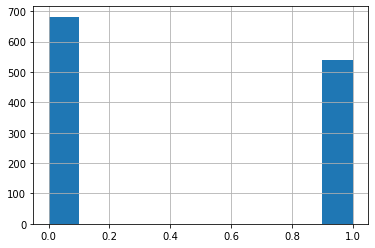

In [5]:
# label successful coin
# set threshold as 0.05 (5%)
df['success'] = df['theoretical_profit'].apply(lambda x: 1 if x>=0.05 else 0)
df = df.sort_index()
print('successful: {}, unsuccessful: {}'.format(
    df[df['success']==1].shape[0], df[df['success']==0].shape[0])) 
df['success'].hist()

In [6]:
# define theoretical return
df['theoretical_return'] = df['theoretical_profit'] +1
# calculate relative volume by coin price
df['relative_volume'] = df['Volume'] / df['Price before pump']

In [7]:
# make dummy variable for exchanges
df['yobit'] = df['Exchange']
df['bittrex'] = df['Exchange']
df['cryptopia'] = df['Exchange']
df['yobit'] = df['yobit'].replace(['Yobit', 'Bittrex', 'Binance', 'Cryptopia'], [1, 0, 0, 0])
df['bittrex'] = df['bittrex'].replace(['Yobit', 'Bittrex', 'Binance', 'Cryptopia'], [0, 1, 0, 0])
df['cryptopia'] = df['cryptopia'].replace(['Yobit', 'Bittrex', 'Binance', 'Cryptopia'], [0, 0, 0, 1])

In [8]:
# make interaction variables
df['volume_yobit'] = df['relative_volume'] * df['yobit']
df['volume_cryptopia'] = df['relative_volume'] * df['cryptopia']
df['volume_bittrex'] = df['relative_volume'] * df['bittrex']

In [9]:
def min_sec(time):
    div = time.find(':')
    minute = int(time[:div])
    second = int(time[div+1:])
    return minute*60 + second

In [10]:
# duration displayed in seconds
df['duration']=df['Duration'].apply(min_sec)

In [11]:
def cleaning(text):
    text = text.replace('$', '')
    text = text.replace(',', '')
    text = text.replace(' ', '')
    return text

In [12]:
def get_coin_info(df):
    
    # collect the coin info 
    name =[]
    files = glob.glob("history/*.csv")
    for file in files:
        name.append(file)
    
    # get the number of P&D for each month
    df['month'] = df.index.month
    df['year'] = df.index.year
    count = df.groupby(['year', 'month']).size().values
    
    start = 0
    for i in range(len(name)):
        df_coin = pd.read_csv(name[i])
        
        # clean the csv file
        df_coin['Market Cap'] = df_coin['Market Cap'].apply(cleaning)
        df_coin['Volume (24h)'] = df_coin['Volume (24h)'].apply(cleaning)
        
        # take out the target month
        month = df.iloc[start:start+count[i],]
        
        # create new columns
        month['ranked'] = 0
        month['coin_cap'] = 0
        month['coin_volume'] = 0
        month['coin_ranking'] = 1001 # consider the unranked coin's ranking as 1001
        
        # match the two sheets 
        for idx in range(0, month.shape[0]):
            for idx2 in range(0, 1000):
                if month['Currency'].iloc[idx] == df_coin['Symbol'].iloc[idx2]:
                    month['ranked'].iloc[idx] = 1
                    month['coin_cap'].iloc[idx] = float(df_coin['Market Cap'].iloc[idx2])
                    month['coin_ranking'].iloc[idx] = int(df_coin['Rank'].iloc[idx2])
                    month['coin_volume'].iloc[idx] = float(df_coin['Volume (24h)'].iloc[idx2])
                    break
        
        if i == 0:
            df_ = month
        else:
            df_ = df_.append(month)
            
        start += count[i]
    
    return df_

In [13]:
df = get_coin_info(df)

In [14]:
print(df.shape)
print(df[df['ranked']==1].shape)
print(df[df['ranked']==0].shape)

(1222, 28)
(1018, 28)
(204, 28)


note that 200 pumps are using coins not in the rankings, but we assume that market cap and volume is very low for these coins; therefore assign 0 for each data

In [15]:
# get time
df['month']= df.index.month
df['weekday']= df.index.weekday
df['hour']= df.index.hour
df['year']= df.index.year

In [16]:
# year dummy
df['2018year'] = df['year'].replace([2018, 2019, 2020, 2021], [1, 0, 0, 0])
df['2019year'] = df['year'].replace([2018, 2019, 2020, 2021], [0, 1, 0, 0])
df['2020year'] = df['year'].replace([2018, 2019, 2020, 2021], [0, 0, 1, 0])
df['2021year'] = df['year'].replace([2018, 2019, 2020, 2021], [0, 0, 0, 1])

In [17]:
# make dummy for AM Time UTC: 0-11
df['AM'] = df['hour'].apply(lambda x: 1 if x <= 11 else 0)

In [18]:
# cyclical representation of time
def cordinate(df, col):
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
    return df

In [19]:
# month
df = cordinate(df, 'month')

<Figure size 288x288 with 0 Axes>

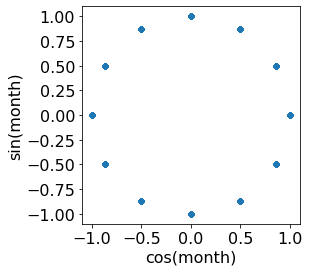

In [20]:
plt.figure(figsize=(4, 4))
df.plot.scatter('month_cos', 'month_sin').set_aspect('equal')
plt.xlabel('cos(month)', fontsize=16)
plt.ylabel('sin(month)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('img/coordinate.jpg', bbox_inches='tight')

In [21]:
# hour
df = cordinate(df, 'hour')

<Figure size 288x288 with 0 Axes>

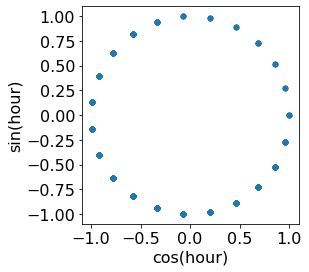

In [22]:
plt.figure(figsize=(4, 4))
df.plot.scatter('hour_cos', 'hour_sin').set_aspect('equal')
plt.xlabel('cos(hour)', fontsize=16)
plt.ylabel('sin(hour)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('img/coordinate2.jpg', bbox_inches='tight')

In [23]:
# channel id
df['channel'] = df['Channel'].factorize()[0]

In [24]:
# to csv file
df.to_csv("pnd_features_new.csv") 

In [25]:
# display the descriptive statistics
pd.options.display.precision = 2
var = ['relative_volume','duration','ranked', 'yobit', 'bittrex', 'cryptopia', 'AM', 
       '2019year', '2020year', '2021year', 'volume_yobit', 'volume_cryptopia', 'volume_bittrex']
df[var].describe()

,relative_volume,duration,ranked,yobit,bittrex,cryptopia,AM,2019year,2020year,2021year,volume_yobit,volume_cryptopia,volume_bittrex
count,1.22e+03,1222.00,1222.00,1222.00,1222.00,1222.00,1222.00,1222.00,1222.00,1222.00,1.22e+03,1.22e+03,1.22e+03
mean,2.27e+07,128.54,0.83,0.18,0.04,0.11,0.15,0.38,0.26,0.17,2.28e+04,1.38e+05,1.48e+05
std,3.74e+08,191.01,0.37,0.39,0.19,0.32,0.36,0.49,0.44,0.38,2.13e+05,8.37e+05,2.49e+06
min,0.00e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00
25%,6.79e+04,12.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00
50%,6.85e+05,57.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00e+00,0.00e+00,0.00e+00
75%,3.35e+06,175.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00e+00,0.00e+00,0.00e+00
max,1.28e+10,1401.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,6.07e+06,1.62e+07,6.99e+07


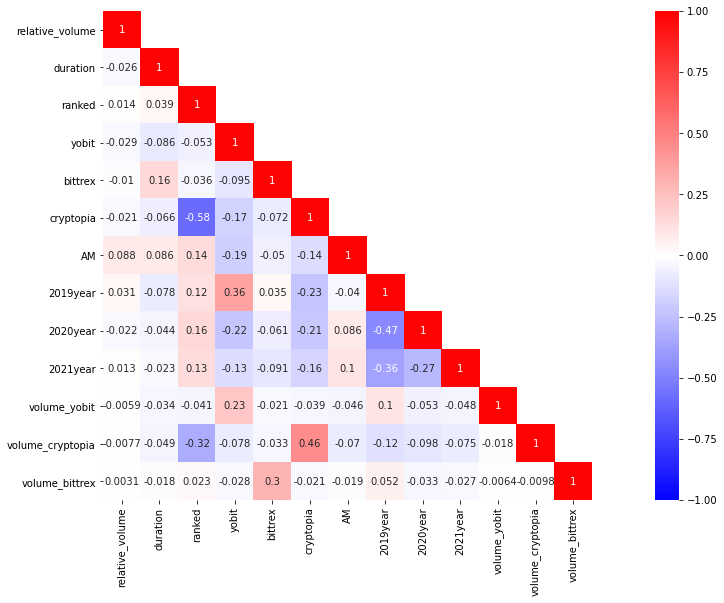

In [26]:
# partial correlation matrix
variables = df[var]
cor_mat= variables[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(22.5,9)
cmap = sns.color_palette("bwr", 200)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True, cmap = cmap, vmin= -1, vmax = 1)

In [27]:
# without Telegram channel effect (from the MLE estimate)
# using statsmodels library
import statsmodels.api as sm

y = np.log(df['theoretical_return'])
X = df[var]
# add constant
X = sm.add_constant(X)

# fit model
model = sm.GLM(y, X, family=sm.families.Gaussian())
result = model.fit()
result.summary()

# the significance did not change from the Bayesian model (except 'bittrex')

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:     theoretical_return   No. Observations:                 1222
Model:                            GLM   Df Residuals:                     1208
Model Family:                Gaussian   Df Model:                           13
Link Function:               identity   Scale:                        0.071592
Method:                          IRLS   Log-Likelihood:                -115.83
Date:                Sat, 03 Apr 2021   Deviance:                       86.483
Time:                        11:09:56   Pearson chi2:                     86.5
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0341      0.040     -0.860      0.390      -0.112       0.044
relative_volume   1.663e-12   2.06e-11      0.081      0.936   -3.87e-11    4.21e-11
duration         -4.497e-05   4.29e-05     -1.047      0.295      -0.000    3.92e-05
ranked               0.0674      0.026      2.577      0.010       0.016       0.119
yobit                0.3961      0.023     16.899      0.000       0.350       0.442
bittrex              0.1028      0.044      2.319      0.020       0.016       0.190
cryptopia            0.3751      0.042      8.994      0.000       0.293       0.457
AM                  -0.0661      0.022     -2.979      0.003      -0.110      -0.023
2019year             0.0681      0.031      2.221      0.026       0.008       0.128
2020year             0.0329      0.033      0.986      0.324      -0.033       0.098
2021year             0.0614      0.035      1.748      0.080      -0.007       0.130
volume_yobit      2.942e-07   3.69e-08      7.974      0.000    2.22e-07    3.67e-07
volume_cryptopia  4.162e-08   1.03e-08      4.027      0.000    2.14e-08    6.19e-08
volume_bittrex      2.9e-09   3.23e-09      0.897      0.370   -3.44e-09    9.24e-09
====================================================================================
"""